In [41]:
%pip install numpy matplotlib jax jaxlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from VisualizeState import VisualizeState
from SimpleSolver import SimpleSolver
import jaxlib

## Kinematics state space model

### State vector x(t) — ordered and explicit (size $19 + 6*i$)

We model a point **sonar** (s) and a point **fish** (i). The global frame and linear kinematics are in **NED** (North–East–Down). Angular rates/accelerations are expressed in the **sonar body** frame.

$$
x(t)=\begin{bmatrix}
\underbrace{p_{sN},p_{sE},p_{sD}}_{\text{sonar position }p_s\in\mathbb{R}^3},
\underbrace{v_{sN},v_{sE},v_{sD}}_{\text{sonar velocity }v_s\in\mathbb{R}^3},
\underbrace{q_w,q_x,q_y,q_z}_{\text{sonar quaternion }q_s\in\mathbb{R}^4},
\underbrace{\omega_x,\omega_y,\omega_z}_{\text{sonar ang. vel. }\omega_s\in\mathbb{R}^3},
\underbrace{a_{sN},a_{sE},a_{sD}}_{\text{sonar lin. accel. }a_s\in\mathbb{R}^3},\;
\underbrace{\alpha_x,\alpha_y,\alpha_z}_{\text{sonar ang. accel. }\alpha_s\in\mathbb{R}^3},
\underbrace{p_{iN},p_{iE},p_{iD}}_{\text{fish position }p_i\in\mathbb{R}^3},\;
\underbrace{v_{iN},v_{iE},v_{iD}}_{\text{fish velocity }v_i\in\mathbb{R}^3}
\end{bmatrix}^{\!\top}
$$

**Index map**

| \(i\) | \(x_i\) | Description | Units | Frame |
|---:|:---|:---|:---:|:---|
| 1 | ($p_{sN}$) | Sonar position, North | m | NED |
| 2 | ($p_{sE}$) | Sonar position, East | m | NED |
| 3 | ($p_{sD}$) | Sonar position, Down | m | NED |
| 4 | ($v_{sN}$) | Sonar velocity, North | m/s | NED |
| 5 | ($v_{sE}$) | Sonar velocity, East | m/s | NED |
| 6 | ($v_{sD}$) | Sonar velocity, Down | m/s | NED |
| 7 | ($q_w$) | Sonar quaternion (scalar part) | – | body→NED |
| 8 | ($q_x$) | Sonar quaternion x | – | body→NED |
| 9 | ($q_y$) | Sonar quaternion y | – | body→NED |
| 10 | ($q_z$) | Sonar quaternion z | – | body→NED |
| 11 | ($\omega_x$) | Sonar angular velocity x | rad/s | body |
| 12 | ($\omega_y$) | Sonar angular velocity y | rad/s | body |
| 13 | ($\omega_z$) | Sonar angular velocity z | rad/s | body |
| 14 | ($a_{sN}$) | Sonar linear acceleration, North | m/s² | NED |
| 15 | ($a_{sE}$) | Sonar linear acceleration, East | m/s² | NED |
| 16 | ($a_{sD}$) | Sonar linear acceleration, Down | m/s² | NED |
| 17 | ($\alpha_x$) | Sonar angular acceleration x | rad/s² | body |
| 18 | ($\alpha_y$) | Sonar angular acceleration y | rad/s² | body |
| 19 | ($\alpha_z$) | Sonar angular acceleration z | rad/s² | body |
| 20 | ($p_{iN}$) | Fish position, North | m | NED |
| 21 | ($p_{iE}$) | Fish position, East | m | NED |
| 22 | ($p_{iD}$) | Fish position, Down | m | NED |
| 23 | ($v_{iN}$) | Fish velocity, North | m/s | NED |
| 24 | ($v_{iE}$) | Fish velocity, East | m/s | NED |
| 25 | ($v_{iD}$) | Fish velocity, Down | m/s | NED |

**Notes**
- Quaternion normalization constraint: ($\|q_s\|=1$) (enforce via renormalization or as an algebraic constraint).
- This is the minimal kinematics set; adding more fish appends (6) states per fish ($[p_{i+1}, v_{i+1}]$).


### Parameters p

We treat fixed quantities (geometry, constants, constraints) as **parameters**. For the point-sonar / point-fish kinematics:

$$
p = \{ \}
$$

**Table — symbols, types, units, meaning**

| Symbol | Type / example | Units | Meaning / how it’s used |
|---|---|---:|---|
| sym exp | type exp | m/s | meaning exp|
| empty | empty | empty | empty |

**Notes**


### Inputs u(t)

We collect all external excitations into a single input vector.

$$
u(t) =
\big[
\underbrace{u_{s,aN}, u_{s,aE}, u_{s,aD}}_\text{linear jerk applied to sonar},
\underbrace{u_{s,αx}, u_{s,αy}, u_{s,αz}}_\text{angular jerk applied to sonar},
\underbrace{u_{i,aN}, u_{i,aE}, u_{i,aD}}_\text{linear accel. applied to fish}
\big]^T
$$

**Meaning**

- $u_{j,a} = [u_{j,aN}, u_{j,aE}, u_{j,aD}]$ — linear jerk applied to the sonar (time derivative of the stored linear acceleration $a_s$), NED frame, units m/s³  
- $u_{j,α} = [u_{j,αx}, u_{j,αy}, u_{j,αz}]$ — angular jerk applied to the sonar (time derivative of the stored angular acceleration $α_s$), body frame, units rad/s³  
- $u_{i,a} = [u_{i,aN}, u_{i,aE}, u_{i,aD}]$ — commanded linear acceleration of the fish, NED frame, units m/s²

**Direct effect on state derivatives**

- $\dot a_s = u_{j,a}$  
- $\dot α_s = u_{j,α}$  
- $\dot v_i = u_{i,a}$

**Notes**

- Setting $u_{j,a} = 0$ and $u_{j,α} = 0$ yields piecewise-constant $a_s$ and $α_s$ between input updates.  
- Setting $u_{i,a} = 0$ gives constant-velocity fish motion (after initialization).


### State-space equations

#### Equations
$$
\dot p_s = v_s \\
\dot v_s = a_s \\
\dot q_s = \tfrac{1}{2}Q(ω_s)q_s \\
\dot ω_s = α_s \\
\dot a_s = u_{s,a} \\
\dot α_s = u_{s,α} \\
\dot p_i = v_i \\
\dot v_i = u_{i,a} \\
$$

Here ($Q(ω_s)\in\mathbb{R}^{4\times4}$) is the quaternion-rate matrix built from the body-frame angular velocity $(ω_s=[ω_x,ω_y,ω_z]^\top)$:

$$
Q(ω_s) =
\begin{bmatrix}
0 & -ω_x & -ω_y & -ω_z\\
ω_x & 0 & ω_z & -ω_y\\
ω_y & -ω_z & 0 & ω_x\\
ω_z & ω_y & -ω_x & 0
\end{bmatrix}
$$

Or expanded:

$$
\dot q_w = -\tfrac{1}{2}(w_x q_x + w_y q_y + w_z q_z) \\
\dot q_x = \tfrac{1}{2}(w_x q_w - w_y q_z + w_z q_y) \\
\dot q_y = \tfrac{1}{2}(w_x q_z + w_y q_w - w_z q_x) \\
\dot q_z = \tfrac{1}{2}(- w_x q_y + w_y q_x + w_z q_w)
$$

#### Matrices

We write the kinematics in the generalized form

$$
E\dot{x}(t) = Ax(t) + Bu(t),
$$

#### Mass/descriptor matrix
$$
E = I_{25}.
$$

#### System matrix (block-partitioned)
Blocks follow the grouping \([\,p_s(3),\, v_s(3),\, q_s(4),\, ω_s(3),\, a_s(3),\, α_s(3),\, p_i(3),\, v_i(3)\,]\).

$$
A(x)=
\begin{bmatrix}
\;0_{3\times3}\;& I_3 & 0_{3\times4} & 0_{3\times3} & 0_{3\times3} & 0_{3\times3} & 0_{3\times3} & 0_{3\times3} \\
0 & 0 & 0 & 0 & I_3 & 0 & 0 & 0 \\
0 & 0 & \tfrac12\,Q(ω_s) & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & I_3 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & I_3 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}.
$$



#### Input matrix
Inputs are grouped as columns $([u_{s,a}(3),u_{s,α}(3),u_{i,a}(3))$.
$$
B =
\begin{bmatrix}
0_{3\times3} & 0_{3\times3} & 0_{3\times3}\\
0 & 0 & 0\\
0_{4\times3} & 0_{4\times3} & 0_{4\times3}\\
0_{3\times3} & 0_{3\times3} & 0_{3\times3}\\
I_3 & 0 & 0\\
0 & I_3 & 0\\
0 & 0 & 0\\
0 & 0 & I_3
\end{bmatrix}.
$$

In [43]:
def Q_matrix(omega: np.ndarray) -> np.ndarray:
    """
    Build the 4x4 quaternion-rate matrix Q(omega) for body-frame angular velocity omega = [wx, wy, wz].
    dq/dt = 0.5 * Q(omega) @ q
    """
    wx, wy, wz = omega
    return np.array([
        [0.0, -wx, -wy, -wz],
        [wx,  0.0,  wz, -wy],
        [wy, -wz,  0.0,  wx],
        [wz,  wy, -wx,  0.0],
    ], dtype=float)

def dqdt(q: np.ndarray, omega: np.ndarray) -> np.ndarray:
    """
    Quaternion time derivative given q (w,x,y,z) and body-frame angular velocity omega (rad/s).
    Uses dq/dt = 0.5 * Q(omega) @ q.
    q is NOT renormalized here (leave that to the integrator or a wrapper).
    """
    return 0.5 * Q_matrix(omega) @ q

def infer_n(x: np.ndarray, u: np.ndarray) -> int:
    """
    Infer the number of fish n from the sizes of state x and input u.
    Also assets that the sizes are consistent with the expected structure.
    State (len = 19 + 6n)
    inputs (len = 6 + 3n)
    """

    x = np.asarray(x).reshape(-1)
    u = np.asarray(u).reshape(-1)
    assert x.size >= 19 and (x.size - 19) % 6 == 0, "State size not consistent with 19 + 6*n"
    assert u.size >= 6 and (u.size - 6) % 3 == 0, "Input size not consistent with 6 + 3*n"
    n_from_x = (x.size - 19) // 6
    n_from_u = (u.size - 6) // 3
    assert n_from_x == n_from_u, f"Inconsistent n: from x={n_from_x}, from u={n_from_u}"
    assert n_from_x >= 1, "This model expects at least 1 fish (n>=1)"
    return int(n_from_x)

def evalf(x: np.ndarray, p: dict, u: np.ndarray) -> np.ndarray:
    """
    Kinematics-only vector field for a point sonar and n point fish.

    State (len = 19 + 6n):
      [ p_s(3), v_s(3), q_s(4), omega_s(3), a_s(3), alpha_s(3), (p_i(3), v_i(3)) x n ]

    Inputs (len = 6 + 3n):
      [ u_s_a(3), u_s_alpha(3), (u_i_a(3)) x n ]
    """
    x = np.asarray(x, dtype=float).reshape(-1)
    u = np.asarray(u, dtype=float).reshape(-1)
    n = infer_n(x, u)

    # Sonar indices
    i_p_s, i_v_s   = slice(0,3),  slice(3,6)
    i_q_s          = slice(6,10)
    i_omega_s      = slice(10,13)
    i_a_s, i_alpha_s = slice(13,16), slice(16,19)

    # Unpack sonar
    v_s     = x[i_v_s]
    q_s     = x[i_q_s]
    omega_s = x[i_omega_s]
    a_s     = x[i_a_s]
    alpha_s = x[i_alpha_s]

    # Inputs (sonar)
    u_s_a     = u[0:3]
    u_s_alpha = u[3:6]

    # Derivatives (sonar)
    dp_s     = v_s
    dv_s     = a_s
    dq_s     = dqdt(q_s, omega_s)
    domega_s = alpha_s
    da_s     = u_s_a
    dalpha_s = u_s_alpha

    dxdt = np.zeros_like(x)
    dxdt[i_p_s]     = dp_s
    dxdt[i_v_s]     = dv_s
    dxdt[i_q_s]     = dq_s
    dxdt[i_omega_s] = domega_s
    dxdt[i_a_s]     = da_s
    dxdt[i_alpha_s] = dalpha_s

    # Fish blocks
    base = 19
    for i in range(n):
        i_pi = slice(base + 6*i,     base + 6*i + 3)
        i_vi = slice(base + 6*i + 3, base + 6*i + 6)
        v_i = x[i_vi]
        u_i_a = u[6 + 3*i : 6 + 3*(i+1)]
        dxdt[i_pi] = v_i
        dxdt[i_vi] = u_i_a

    return dxdt

In [44]:
# Homebrewed unit tests and regression tests
# -------- Tests --------
def assert_close(name, actual, expected, tol=1e-9):
    actual = np.asarray(actual, dtype=float).reshape(-1)
    expected = np.asarray(expected, dtype=float).reshape(-1)
    ok = np.allclose(actual, expected, atol=tol, rtol=0)
    status = "PASS" if ok else "FAIL"
    print(f"[{status}] {name}")
    if not ok:
        print("  actual  =", actual)
        print("  expected=", expected)

def fish_slices(i, base=19):
    return slice(base + 6*i, base + 6*i + 3), slice(base + 6*i + 3, base + 6*i + 6)

def step_forward_euler_n(x, p, u, dt):
    dx = evalf(x, p, u)
    x_next = x + dt * dx
    q = x_next[6:10]
    nrm = np.linalg.norm(q)
    if nrm > 0:
        x_next[6:10] = q / nrm
    return x_next

def simulate_fe_n(x0, p, u, T, dt):
    steps = int(np.round(T / dt))
    traj = np.zeros((steps + 1, x0.size))
    traj[0] = x0.copy()
    for k in range(steps):
        traj[k+1] = step_forward_euler_n(traj[k], p, u, dt)
    return traj

def run_unit_tests_multi():
    print("-----------Unit tests (multi-fish, 3-arg evalf)---------------")
    for n in [1, 2, 5]:
        x = np.zeros(19 + 6*n, dtype=float)
        x[6] = 1.0
        u = np.zeros(6 + 3*n, dtype=float)

        v_s = np.array([1.0, -2.0, 0.5])
        a_s = np.array([0.1, 0.0, -0.05])
        u_s_a = np.array([0.01, -0.02, 0.03])
        u_s_alpha = np.array([0.0, 0.0, 0.5])
        omega = np.array([0.0, 0.0, 2.0])

        x[3:6]   = v_s
        x[13:16] = a_s
        x[10:13] = omega
        u[0:3]   = u_s_a
        u[3:6]   = u_s_alpha

        for i in range(n):
            i_pi, i_vi = fish_slices(i)
            v_i = np.array([0.2*(i+1), -0.1*i, 0.05])
            a_i = np.array([0.01*i, 0.02, -0.03*(i%2)])
            x[i_vi] = v_i
            u[6 + 3*i : 6 + 3*(i+1)] = a_i

        dx = evalf(x, {}, u)

        assert_close(f"(n={n}) dp_s = v_s", dx[0:3], v_s)
        assert_close(f"(n={n}) dv_s = a_s", dx[3:6], a_s)
        expect_dq = 0.5 * np.array([0.0, omega[0], omega[1], omega[2]])
        assert_close(f"(n={n}) dq_s with ωz", dx[6:10], expect_dq)
        assert_close(f"(n={n}) da_s = u_s_a", dx[13:16], u_s_a)
        assert_close(f"(n={n}) dω_s = α_s", dx[10:13], x[16:19])
        assert_close(f"(n={n}) dα_s = u_s_alpha", dx[16:19], u_s_alpha)

        for i in range(n):
            i_pi, i_vi = fish_slices(i)
            v_i = x[i_vi]
            a_i = u[6 + 3*i : 6 + 3*(i+1)]
            assert_close(f"(n={n}, i={i}) dp_i = v_i", dx[i_pi], v_i)
            assert_close(f"(n={n}, i={i}) dv_i = u_i_a", dx[i_vi], a_i)

def run_regression_tests_multi():
    print("-----------Regression tests (multi-fish, 3-arg evalf)---------------")
    tol = 5e-3

    for n in [1, 2, 5, 10, 20]:
        x0 = np.zeros(19 + 6*n); x0[6] = 1.0
        v_s = np.array([1.0, 2.0, -0.5]); x0[3:6] = v_s
        u = np.zeros(6 + 3*n)
        T, dt = 6.0, 0.01
        traj = simulate_fe_n(x0, {}, u, T, dt)
        p_s_T = traj[-1, 0:3]
        expect_ps = v_s * T
        assert_close(f"(n={n}) Straight-line p_s(T)=v_s*T", p_s_T, expect_ps, tol=tol)

        x0 = np.zeros(19 + 6*n); x0[6] = 1.0
        a_s = np.array([0.08, -0.02, 0.0]); x0[13:16] = a_s
        v0 = np.array([0.3, -0.2, 0.0]); x0[3:6] = v0
        u = np.zeros(6 + 3*n)
        T, dt = 4.0, 0.001
        traj = simulate_fe_n(x0, {}, u, T, dt)
        p_T = traj[-1, 0:3]; v_T = traj[-1, 3:6]
        expect_v = v0 + a_s * T
        expect_p = v0 * T + 0.5 * a_s * T**2
        assert_close(f"(n={n}) Const accel v_s(T)", v_T, expect_v, tol=tol)
        assert_close(f"(n={n}) Const accel p_s(T)", p_T, expect_p, tol=tol)

        x0 = np.zeros(19 + 6*n); x0[6] = 1.0
        omega = np.array([0.0, 0.0, 1.0]); x0[10:13] = omega
        u = np.zeros(6 + 3*n)
        T, dt = 2.0, 0.001
        traj = simulate_fe_n(x0, {}, u, T, dt)
        q_T = traj[-1, 6:10]
        theta = omega[2] * T
        q_expect = np.array([np.cos(theta/2), 0.0, 0.0, np.sin(theta/2)])
        if np.dot(q_T, q_expect) < 0:
            q_T = -q_T
        assert_close(f"(n={n}) Constant spin quaternion", q_T, q_expect, tol=tol)

        x0 = np.zeros(19 + 6*n); x0[6] = 1.0
        u = np.zeros(6 + 3*n)
        for i in range(n):
            i_pi, i_vi = fish_slices(i)
            p0_i = np.array([i*0.5, -i*0.25, 1.0])
            v0_i = np.array([0.1*(i+1), -0.05*i, 0.0])
            a_i  = np.array([0.02*(i%3), 0.01, -0.01])
            x0[i_pi] = p0_i
            x0[i_vi] = v0_i
            u[6 + 3*i : 6 + 3*(i+1)] = a_i

        T, dt = 3.0, 0.002
        traj = simulate_fe_n(x0, {}, u, T, dt)
        xT = traj[-1]

        for i in range(n):
            i_pi, i_vi = fish_slices(i)
            p0_i = np.array([i*0.5, -i*0.25, 1.0])
            v0_i = np.array([0.1*(i+1), -0.05*i, 0.0])
            a_i  = u[6 + 3*i : 6 + 3*(i+1)]
            expect_v = v0_i + a_i * T
            expect_p = p0_i + v0_i * T + 0.5 * a_i * T**2
            assert_close(f"(n={n}, i={i}) fish v_i(T)", xT[i_vi], expect_v, tol=1e-2)
            assert_close(f"(n={n}, i={i}) fish p_i(T)", xT[i_pi], expect_p, tol=1e-2)

run_unit_tests_multi()
run_regression_tests_multi()

-----------Unit tests (multi-fish, 3-arg evalf)---------------
[PASS] (n=1) dp_s = v_s
[PASS] (n=1) dv_s = a_s
[PASS] (n=1) dq_s with ωz
[PASS] (n=1) da_s = u_s_a
[PASS] (n=1) dω_s = α_s
[PASS] (n=1) dα_s = u_s_alpha
[PASS] (n=1, i=0) dp_i = v_i
[PASS] (n=1, i=0) dv_i = u_i_a
[PASS] (n=2) dp_s = v_s
[PASS] (n=2) dv_s = a_s
[PASS] (n=2) dq_s with ωz
[PASS] (n=2) da_s = u_s_a
[PASS] (n=2) dω_s = α_s
[PASS] (n=2) dα_s = u_s_alpha
[PASS] (n=2, i=0) dp_i = v_i
[PASS] (n=2, i=0) dv_i = u_i_a
[PASS] (n=2, i=1) dp_i = v_i
[PASS] (n=2, i=1) dv_i = u_i_a
[PASS] (n=5) dp_s = v_s
[PASS] (n=5) dv_s = a_s
[PASS] (n=5) dq_s with ωz
[PASS] (n=5) da_s = u_s_a
[PASS] (n=5) dω_s = α_s
[PASS] (n=5) dα_s = u_s_alpha
[PASS] (n=5, i=0) dp_i = v_i
[PASS] (n=5, i=0) dv_i = u_i_a
[PASS] (n=5, i=1) dp_i = v_i
[PASS] (n=5, i=1) dv_i = u_i_a
[PASS] (n=5, i=2) dp_i = v_i
[PASS] (n=5, i=2) dv_i = u_i_a
[PASS] (n=5, i=3) dp_i = v_i
[PASS] (n=5, i=3) dv_i = u_i_a
[PASS] (n=5, i=4) dp_i = v_i
[PASS] (n=5, i=4) dv_i = u

In [45]:
# SimpleSolver test code
# Scenario with analytic solutions
n = 3
N = 19 + 6*n
x_start = np.zeros(N, dtype=float)
x_start[6] = 1.0
v0_s = np.array([0.3, -0.2, 0.0])
a_s  = np.array([0.08, -0.02, 0.00])
x_start[3:6]   = v0_s
x_start[13:16] = a_s

p0_list = []
v0_list = []
a_list  = []
for i in range(n):
    p0_i = np.array([0.5*i, -0.25*i, 1.0])
    v0_i = np.array([0.1*(i+1), -0.05*i, 0.0])
    a_i  = np.array([0.02*(i%3), 0.01, -0.01])
    p0_list.append(p0_i); v0_list.append(v0_i); a_list.append(a_i)
    base = 19 + 6*i
    x_start[base:base+3]   = p0_i
    x_start[base+3:base+6] = v0_i

def eval_u(t):
    u = np.zeros(6 + 3*n, dtype=float)
    for i in range(n):
        u[6 + 3*i : 6 + 3*(i+1)] = a_list[i]
    return u

T = 5.0
w = 0.001
NumIter = int(T / w)
X, t = SimpleSolver(evalf, x_start, {}, eval_u, NumIter, w=w, visualize=False)

xT = X[:, -1]

def assert_close(name, actual, expected, tol=5e-3):
    actual = np.asarray(actual).reshape(-1)
    expected = np.asarray(expected).reshape(-1)
    ok = np.allclose(actual, expected, atol=tol, rtol=0)
    status = "PASS" if ok else "FAIL"
    print(f"[{status}] {name}")
    if not ok:
        print("  actual  =", actual)
        print("  expected=", expected)

# Expectations
p0_s = np.zeros(3)
expect_vs = v0_s + a_s * T
expect_ps = p0_s + v0_s * T + 0.5 * a_s * T**2
assert_close("Sonar velocity v_s(T)", xT[3:6], expect_vs)
assert_close("Sonar position p_s(T)", xT[0:3], expect_ps)

for i in range(n):
    base = 19 + 6*i
    vexp = v0_list[i] + a_list[i] * T
    pexp = p0_list[i] + v0_list[i] * T + 0.5 * a_list[i] * T**2
    assert_close(f"Fish {i} velocity v_i(T)", xT[base+3:base+6], vexp)
    assert_close(f"Fish {i} position p_i(T)", xT[base:base+3], pexp)

started running a simple solver, please wait...
[PASS] Sonar velocity v_s(T)
[PASS] Sonar position p_s(T)
[PASS] Fish 0 velocity v_i(T)
[PASS] Fish 0 position p_i(T)
[PASS] Fish 1 velocity v_i(T)
[PASS] Fish 1 position p_i(T)
[PASS] Fish 2 velocity v_i(T)
[PASS] Fish 2 position p_i(T)


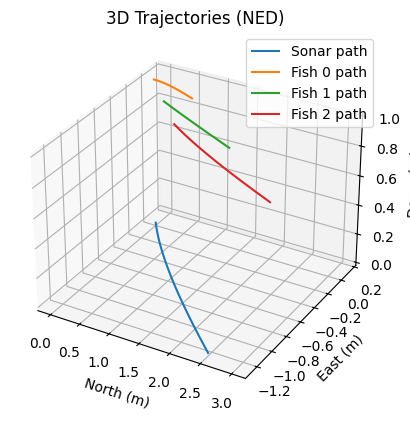

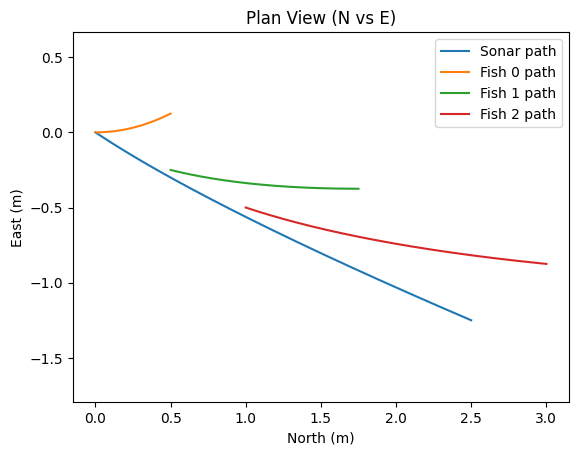

In [46]:
def infer_n_from_state_length(N: int) -> int:
    assert N >= 19 and (N - 19) % 6 == 0, "State size not consistent with 19 + 6*n"
    return (N - 19) // 6

def extract_positions_over_time(X: np.ndarray):
    """
    X shape expected: (state_dim, num_steps). Returns:
      Ps : (num_steps, 3) sonar positions
      Pf_list : list of (num_steps, 3) positions for each fish
    """
    if X.ndim != 2:
        raise ValueError("X must be a 2D array with shape (state_dim, num_steps)")
    N, K = X.shape
    n = infer_n_from_state_length(N)
    Ps = X[0:3, :].T  # (K,3)

    Pf_list = []
    base = 19
    for i in range(n):
        Pf = X[base + 6*i : base + 6*i + 3, :].T  # (K,3)
        Pf_list.append(Pf)
    return Ps, Pf_list

def plot_3d_trajectories(X: np.ndarray, t: np.ndarray):
    Ps, Pf_list = extract_positions_over_time(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(Ps[:,0], Ps[:,1], Ps[:,2], label="Sonar path")
    for i, Pf in enumerate(Pf_list):
        ax.plot(Pf[:,0], Pf[:,1], Pf[:,2], label=f"Fish {i} path")
    ax.set_xlabel("North (m)")
    ax.set_ylabel("East (m)")
    ax.set_zlabel("Down (m)")
    ax.set_title("3D Trajectories (NED)")
    ax.legend()
    plt.show()

def plot_plan_view_NE(X: np.ndarray, t: np.ndarray):
    Ps, Pf_list = extract_positions_over_time(X)
    plt.figure()
    plt.plot(Ps[:,0], Ps[:,1], label="Sonar path")
    for i, Pf in enumerate(Pf_list):
        plt.plot(Pf[:,0], Pf[:,1], label=f"Fish {i} path")
    plt.xlabel("North (m)")
    plt.ylabel("East (m)")
    plt.title("Plan View (N vs E)")
    plt.legend()
    plt.axis('equal')
    plt.show()

# Try to use existing X, t from the notebook. If not present, raise a friendly error.
try:
    X  # noqa: F821
    t  # noqa: F821
except NameError as e:
    raise RuntimeError("X and t were not found in this kernel. Please run the SimpleSolver block first.") from e

# Generate the figures
plot_3d_trajectories(X, t)
plot_plan_view_NE(X, t)

started running a simple solver, please wait...


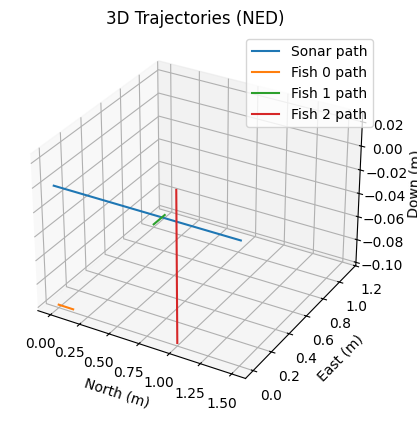

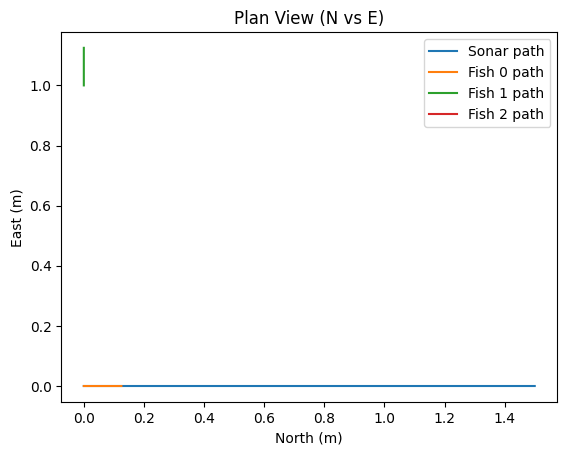

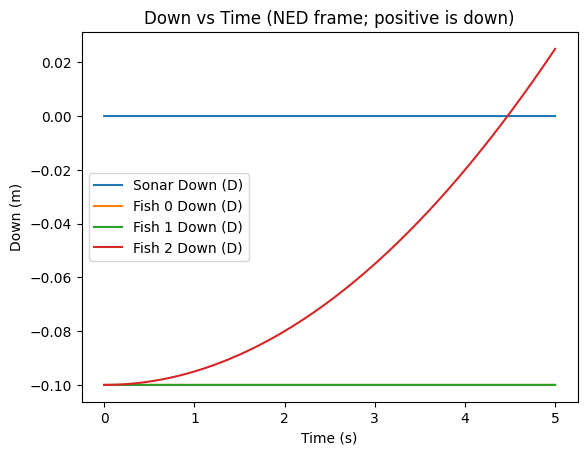

In [47]:
# SimpleSolver wrapper with a friendly params dict, plus plotting.
# This cell defines:
#   - run_simplesolver_scenario(params): main entry point (returns X, t)
#   - An example 'params' dict you can tweak
#   - A demo call that runs and plots
#
# Requirements/assumptions:
#   * evalf(x, p, u) is already defined in the notebook (our model).
#   * SimpleSolver.py is available.

# --- Utility: ensure evalf exists ---
try:
    evalf
except NameError:
    raise RuntimeError("evalf(x, p, u) not found. Run the cell that defines evalf first.")

# --- Helpers: array coercion & validation ---
def vec3(x):
    a = np.asarray(x, dtype=float).reshape(-1)
    if a.size != 3:
        raise ValueError(f"Expected length-3 vector, got shape {a.shape}")
    return a

def vec4(x):
    a = np.asarray(x, dtype=float).reshape(-1)
    if a.size != 4:
        raise ValueError(f"Expected length-4 vector, got shape {a.shape}")
    return a

def is_callable(x):
    return callable(x)

# --- Plot helpers (1 chart per figure, no explicit colors) ---
def infer_n_from_state_length(N: int) -> int:
    assert N >= 19 and (N - 19) % 6 == 0, "State size not consistent with 19 + 6*n"
    return (N - 19) // 6

def extract_positions_over_time(X: np.ndarray):
    if X.ndim != 2:
        raise ValueError("X must be (state_dim, num_steps)")
    N, K = X.shape
    n = infer_n_from_state_length(N)
    Ps = X[0:3, :].T
    Pf_list = []
    base = 19
    for i in range(n):
        Pf = X[base + 6*i : base + 6*i + 3, :].T
        Pf_list.append(Pf)
    return Ps, Pf_list

def plot_3d_trajectories(X: np.ndarray, t: np.ndarray):
    Ps, Pf_list = extract_positions_over_time(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(Ps[:,0], Ps[:,1], Ps[:,2], label="Sonar path")
    for i, Pf in enumerate(Pf_list):
        ax.plot(Pf[:,0], Pf[:,1], Pf[:,2], label=f"Fish {i} path")
    ax.set_xlabel("North (m)")
    ax.set_ylabel("East (m)")
    ax.set_zlabel("Down (m)")
    ax.set_title("3D Trajectories (NED)")
    ax.legend()
    plt.show()

def plot_plan_view_NE(X: np.ndarray, t: np.ndarray):
    Ps, Pf_list = extract_positions_over_time(X)
    plt.figure()
    plt.plot(Ps[:,0], Ps[:,1], label="Sonar path")
    for i, Pf in enumerate(Pf_list):
        plt.plot(Pf[:,0], Pf[:,1], label=f"Fish {i} path")
    plt.xlabel("North (m)")
    plt.ylabel("East (m)")
    plt.title("Plan View (N vs E)")
    plt.legend()
    plt.axis('equal')
    plt.show()

def plot_down_vs_time(X: np.ndarray, t: np.ndarray):
    Ps, Pf_list = extract_positions_over_time(X)
    plt.figure()
    plt.plot(t, Ps[:,2], label="Sonar Down (D)")
    for i, Pf in enumerate(Pf_list):
        plt.plot(t, Pf[:,2], label=f"Fish {i} Down (D)")
    plt.xlabel("Time (s)")
    plt.ylabel("Down (m)")
    plt.title("Down vs Time (NED frame; positive is down)")
    plt.legend()
    plt.show()

# --- Main wrapper ---
def run_simplesolver_scenario(params: dict, *, do_plots: bool = True):
    """
    Run our kinematics model with the course SimpleSolver using a friendly params dict.
    Returns (X, t), where X is (state_dim, num_steps), t is (num_steps,).

    PSEUDOCODE (what this wrapper does):
      1) Read inputs from 'params' and build state size:
           n = params['n']                        # number of fish
           T = params['T']                        # total simulation time [s]
           dt = params['dt']                      # solver step size w [s]
      2) Build initial state x0 of length 19 + 6*n
           - sonar: p0, v0, q0, omega0, a0, alpha0
           - each fish i: p0_i, v0_i
      3) Build input function eval_u(t) of length 6 + 3*n
           - sonar: jerk (linear) and ang_jerk (angular) as constants or callables
           - each fish i: accel as constant or callable
      4) Call SimpleSolver(evalf, x0, p={}, eval_u, NumIter=int(T/dt), w=dt)
      5) Optionally plot 3 figures: 3D trajectory, NE plan view, Down vs time

    PARAMS DICT (keys and defaults):
      params = {
        'n': 3,                 # number of fish (>=1)
        'T': 5.0,               # total sim time [s]
        'dt': 0.001,            # solver step (w) [s]
        'visualize': False,     # pass through to SimpleSolver (we don't rely on it)

        'sonar': {
          'p0':      [0,0,0],       # initial position NED [m]
          'v0':      [0,0,0],       # initial velocity NED [m/s]
          'q0':      [1,0,0,0],     # initial quaternion [w,x,y,z]
          'omega0':  [0,0,0],       # initial angular velocity [rad/s] (body)
          'a0':      [0,0,0],       # initial linear accel state [m/s^2] (NED)
          'alpha0':  [0,0,0],       # initial angular accel state [rad/s^2] (body)
          'jerk':    [0,0,0],       # sonar linear jerk input [m/s^3] OR callable t->(3,)
          'ang_jerk':[0,0,0],       # sonar angular jerk input [rad/s^3] OR callable t->(3,)
        },

        # fish list must have length n; if shorter, remaining fish use defaults
        'fish': [
          { 'p0':[...], 'v0':[...], 'accel':[ax,ay,az] OR callable t->(3,) },
          ...
        ],
      }
    """
    # --- 1) Read top-level settings ---
    n = int(params.get('n', 1))
    if n < 1:
        raise ValueError("params['n'] must be >= 1")
    T = float(params.get('T', 5.0))
    dt = float(params.get('dt', 1e-3))
    visualize = bool(params.get('visualize', False))

    # --- 2) Build initial state x0 ---
    N = 19 + 6*n
    x0 = np.zeros(N, dtype=float)

    sonar = params.get('sonar', {})
    p0_s     = vec3(sonar.get('p0',     [0,0,0]))
    v0_s     = vec3(sonar.get('v0',     [0,0,0]))
    q0_s     = vec4(sonar.get('q0',     [1,0,0,0]))
    omega0_s = vec3(sonar.get('omega0', [0,0,0]))
    a0_s     = vec3(sonar.get('a0',     [0,0,0]))
    alpha0_s = vec3(sonar.get('alpha0', [0,0,0]))

    # Place sonar in state vector
    x0[0:3]   = p0_s
    x0[3:6]   = v0_s
    x0[6:10]  = q0_s / (np.linalg.norm(q0_s) or 1.0)  # normalize to be safe
    x0[10:13] = omega0_s
    x0[13:16] = a0_s
    x0[16:19] = alpha0_s

    # Fish defaults
    fish_defaults = {'p0': [0,0,0], 'v0': [0,0,0], 'accel': [0,0,0]}
    fish_list = params.get('fish', [])
    if len(fish_list) < n:
        fish_list = fish_list + [fish_defaults]*(n - len(fish_list))

    for i in range(n):
        fi = fish_list[i] if i < len(fish_list) else fish_defaults
        p0_i = vec3(fi.get('p0', [0,0,0]))
        v0_i = vec3(fi.get('v0', [0,0,0]))
        base = 19 + 6*i
        x0[base:base+3]   = p0_i
        x0[base+3:base+6] = v0_i

    # --- 3) Build input function u(t) ---
    jerk     = sonar.get('jerk', [0,0,0])
    ang_jerk = sonar.get('ang_jerk', [0,0,0])
    jerk_fun     = jerk if is_callable(jerk) else (lambda t, J=vec3(jerk): J)
    ang_jerk_fun = ang_jerk if is_callable(ang_jerk) else (lambda t, A=vec3(ang_jerk): A)

    fish_accel_funs = []
    for i in range(n):
        acc = fish_list[i].get('accel', [0,0,0])
        if is_callable(acc):
            fish_accel_funs.append(acc)
        else:
            a = vec3(acc)
            fish_accel_funs.append(lambda t, A=a: A)  # bind a by default arg

    def eval_u(t):
        u = np.zeros(6 + 3*n, dtype=float)
        u[0:3] = jerk_fun(t)      # sonar linear jerk
        u[3:6] = ang_jerk_fun(t)  # sonar angular jerk
        for i in range(n):
            u[6 + 3*i : 6 + 3*(i+1)] = fish_accel_funs[i](t)
        return u

    # --- 4) Call SimpleSolver ---
    NumIter = int(np.round(T / dt))
    X, tvec = SimpleSolver(evalf, x0, {}, eval_u, NumIter, w=dt, visualize=visualize)

    # --- 5) Plots ---
    if do_plots:
        plot_3d_trajectories(X, tvec)
        plot_plan_view_NE(X, tvec)
        plot_down_vs_time(X, tvec)

    return X, tvec

# ---------- Example params dict & demo run ----------
example_params = {
    'n': 3,
    'T': 5.0,
    'dt': 0.001,
    'visualize': False,
    'sonar': {
        'p0': [0, 0, 0],
        'v0': [0.3, 0.0, 0.0],
        'q0': [1, 0, 0, 0],
        'omega0': [0.0, 0.0, 0.0],
        'a0': [0.0, 0.0, 0.0],
        'alpha0': [0.0, 0.0, 0.0],
        'jerk': [0.0, 0.0, 0.0],
        'ang_jerk': [0.0, 0.0, 0.0],
    },
    'fish': [#  x      y      z           vx     vy     vz        ax   ay   az
        {'p0': [0.0,  0.0, -0.1], 'v0': [0.0,  0.0,  0.0], 'accel': [0.01, 0.0, 0.0]},
        {'p0': [0.0, 1.0, -0.1], 'v0': [0.0,  0.0,  0.0], 'accel': [0.0,  0.01, 0.0]},
        {'p0': [1.0, 0.0, -0.1], 'v0': [0.0,  0.0,  0.0], 'accel': [0.0, 0.0, 0.01]},
    ]
}

# test run:
X_demo, t_demo = run_simplesolver_scenario(example_params, do_plots=True)
